In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/numerical-data/numerical data.csv
/kaggle/input/gwc-plant-disease/GWC.csv
/kaggle/input/plant-num-data/num_data.csv
/kaggle/input/plant-disease/best_model.keras
/kaggle/input/plant-disease/model.pkl
/kaggle/input/plant-disease/scaler.pkl
/kaggle/input/plant-disease/image_data/image_data/Anthracnose/20230726_093014.jpg
/kaggle/input/plant-disease/image_data/image_data/Anthracnose/20230804_114043.jpg
/kaggle/input/plant-disease/image_data/image_data/Anthracnose/20230512_182454.jpg
/kaggle/input/plant-disease/image_data/image_data/Anthracnose/20230801_155448.jpg
/kaggle/input/plant-disease/image_data/image_data/Anthracnose/20230513_173141.jpg
/kaggle/input/plant-disease/image_data/image_data/Anthracnose/20230817_163611.jpg
/kaggle/input/plant-disease/image_data/image_data/Anthracnose/20230822_185220.jpg
/kaggle/input/plant-disease/image_data/image_data/Anthracnose/20230318_115226.jpg
/kaggle/input/plant-disease/image_data/image_data/Anthracnose/20230329_115259.jpg
/kaggle/in

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from transformers import TFViTForImageClassification
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Flatten, BatchNormalization, LayerNormalization, MultiHeadAttention, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# ==================================================
# 1. SENSOR DATA PREPROCESSING (FT-Transformer)
# ==================================================
data2 = pd.read_csv("/kaggle/input/plant-num-data/num_data.csv")
numerical_data = data2[['Ambient_Temperature', 'Ambient_Humidity', 'Soil_Temperature', 
                        'Leaf_Wetness_Duration', 'Soil_Moisture',
                        'leaf_spot', 'Anthracnose', 'Healthy']].copy()

# Handle overlapping multi-label samples.
samples_both_diseases = numerical_data[(numerical_data['leaf_spot'] == 1) & (numerical_data['Anthracnose'] == 1)]
numerical_data = numerical_data.drop(samples_both_diseases.index)

# Create redundant samples so that each sample has only one disease.
redundant_class0 = samples_both_diseases.copy()
redundant_class0['leaf_spot'] = 1
redundant_class0['Anthracnose'] = 0
redundant_class0['Healthy'] = 0

redundant_class1 = samples_both_diseases.copy()
redundant_class1['leaf_spot'] = 0
redundant_class1['Anthracnose'] = 1
redundant_class1['Healthy'] = 0

numerical_data = pd.concat([numerical_data, redundant_class0, redundant_class1])
numerical_data.reset_index(drop=True, inplace=True)

numerical_features = numerical_data.iloc[:, :5].values
labels = numerical_data.iloc[:, -3:].values

# Split sensor data.
x_train, x_test, y_train, y_test = train_test_split(
    numerical_features, labels, test_size=0.2, random_state=42, stratify=labels
)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

scaler = StandardScaler()
scaler.fit(x_train)
numerical_x_train = scaler.transform(x_train)
numerical_x_val = scaler.transform(x_val)
numerical_x_test = scaler.transform(x_test)

# ==================================================
# 2. IMAGE DATA PREPARATION & SPLITTING (ViT)
# ==================================================
DATA_PATH = '/kaggle/input/plant-disease/image_data/image_data'
anthracnose_paths = glob.glob(os.path.join(DATA_PATH, 'Anthracnose', '*.jpg'))
healthy_paths     = glob.glob(os.path.join(DATA_PATH, 'Healthy', '*.jpg'))
leaf_spot_paths   = glob.glob(os.path.join(DATA_PATH, 'leaf_spot', '*.jpg'))

anthracnose_df = pd.DataFrame(anthracnose_paths, columns=['image_path'])
anthracnose_df['class'] = 'Anthracnose'
healthy_df = pd.DataFrame(healthy_paths, columns=['image_path'])
healthy_df['class'] = 'Healthy'
leaf_spot_df = pd.DataFrame(leaf_spot_paths, columns=['image_path'])
leaf_spot_df['class'] = 'leaf_spot'

df = pd.concat([anthracnose_df, healthy_df, leaf_spot_df], ignore_index=True)
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df['class'], random_state=42)

# ==================================================
# 3. BALANCED CUSTOM GENERATOR
# ==================================================
def balanced_custom_generator(numerical_data, sensor_labels, image_df, batch_size, target_size, rescale=1./255):
    sensor_class = np.argmax(sensor_labels, axis=1)
    unique_classes = np.unique(sensor_class)
    sensor_idx_by_class = {cl: np.where(sensor_class == cl)[0] for cl in unique_classes}
    label_map = {0: 'leaf_spot', 1: 'Anthracnose', 2: 'Healthy'}
    image_paths_by_class = {cl: image_df[image_df['class'] == label_map[cl]]['image_path'].tolist() for cl in unique_classes}
    sensor_counters = {cl: 0 for cl in unique_classes}
    image_counters = {cl: 0 for cl in unique_classes}
    while True:
        batch_numerical = []
        batch_images = []
        batch_labels = []
        for _ in range(batch_size):
            chosen_class = np.random.choice(unique_classes)
            sensor_idx = sensor_idx_by_class[chosen_class][sensor_counters[chosen_class] % len(sensor_idx_by_class[chosen_class])]
            sensor_counters[chosen_class] += 1
            sensor_sample = numerical_data[sensor_idx]
            img_path = image_paths_by_class[chosen_class][image_counters[chosen_class] % len(image_paths_by_class[chosen_class])]
            image_counters[chosen_class] += 1
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img, data_format="channels_last")
            img_array = img_array * rescale
            img_mean = np.mean(img_array)
            img_std = np.std(img_array) + 1e-7
            img_array = (img_array - img_mean) / img_std
            batch_numerical.append(sensor_sample)
            batch_images.append(img_array)
            one_hot = np.zeros(sensor_labels.shape[1])
            one_hot[chosen_class] = 1
            batch_labels.append(one_hot)
        yield ((np.array(batch_numerical), np.array(batch_images)), np.array(batch_labels))

# ==================================================
# 4. MODEL ARCHITECTURE DEFINITION
# ==================================================
# 4.1 FTTransformerEncoder and FTTransformer for sensor data.
class FTTransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, numerical_features, categorical_features, numerical_data, categorical_data, y,
                 numerical_embedding_type='linear', embedding_dim=64, depth=2, heads=6,
                 attn_dropout=0.1, ff_dropout=0.1, explainable=False, **kwargs):
        super(FTTransformerEncoder, self).__init__(**kwargs)
        self.numerical_features = numerical_features
        self.embedding_dim = embedding_dim
        self.depth = depth
        self.heads = heads
        self.attn_dropout = attn_dropout
        self.ff_dropout = ff_dropout
        self.explainable = explainable
        self.embedding = Dense(embedding_dim, activation='linear')
        self.encoder_layers = []
        for _ in range(depth):
            mha = MultiHeadAttention(num_heads=heads, key_dim=embedding_dim, dropout=attn_dropout)
            norm1 = LayerNormalization()
            ffn = tf.keras.Sequential([
                Dense(embedding_dim * 4, activation=tf.nn.gelu),
                Dense(embedding_dim)
            ])
            norm2 = LayerNormalization()
            dropout = Dropout(ff_dropout)
            self.encoder_layers.append({
                'mha': mha,
                'norm1': norm1,
                'ffn': ffn,
                'norm2': norm2,
                'dropout': dropout
            })
            
    def call(self, inputs):
        x = tf.expand_dims(inputs, -1)
        x = self.embedding(x)
        for layer in self.encoder_layers:
            attn_output = layer['mha'](x, x)
            x = layer['norm1'](x + attn_output)
            ffn_output = layer['ffn'](x)
            ffn_output = layer['dropout'](ffn_output)
            x = layer['norm2'](x + ffn_output)
        return x

class FTTransformer(tf.keras.Model):
    def __init__(self, encoder, out_dim, out_activation, **kwargs):
        super(FTTransformer, self).__init__(**kwargs)
        self.encoder = encoder
        self.flatten = Flatten()
        self.out_layer = Dense(out_dim, activation=out_activation)
        
    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.flatten(x)
        return self.out_layer(x)

# 4.2 Custom ViT layer.
class ViTLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ViTLayer, self).__init__(**kwargs)
        self.vit_model = TFViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
        # Ensure the model returns the hidden states via its .vit attribute.
    def call(self, inputs, training=False):
        # Transpose input from channels-last to channels-first.
        x = tf.transpose(inputs, perm=(0, 3, 1, 2))  # (batch, 3, 224, 224)
        # Call the underlying ViT transformer (the classification head is not used).
        outputs = self.vit_model.vit(x, training=training)
        # Retrieve the last hidden state.
        out = outputs.last_hidden_state  # Expected shape: (batch, 197, 768)
        return out

# 4.3 Build the Ensemble Model.
numerical_input = Input(shape=(5,), name='numerical_input')
image_input = Input(shape=(224, 224, 3), name='image_input')

NUMERIC_FEATURES = ['Ambient_Temperature', 'Ambient_Humidity', 'Soil_Temperature',
                    'Leaf_Wetness_Duration', 'Soil_Moisture']
dummy_numerical_data = tf.zeros((1, len(NUMERIC_FEATURES)))
ft_linear_encoder = FTTransformerEncoder(
    numerical_features=NUMERIC_FEATURES,
    categorical_features=[],
    numerical_data=dummy_numerical_data,
    categorical_data=None,
    y=None,
    numerical_embedding_type='linear',
    embedding_dim=64,
    depth=2,
    heads=6,
    attn_dropout=0.1,
    ff_dropout=0.1,
    explainable=False
)
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=3,
    out_activation="sigmoid"
)
ft_output = ft_linear_transformer(numerical_input)

vit_layer = ViTLayer()
vit_output = vit_layer(image_input)  # Expected shape: (batch, 197, 768)

vit_out = Flatten()(vit_output)
vit_out = BatchNormalization()(vit_out)
vit_out = Dense(11, activation=tf.nn.gelu)(vit_out)
vit_out = BatchNormalization()(vit_out)

combinedInput = Concatenate()([ft_output, vit_out])
m = Dense(16, activation='relu')(combinedInput)
m = Dense(12, activation='relu')(m)
m = Dense(3, activation='sigmoid')(m)

ensemble_model = Model(inputs=[numerical_input, image_input], outputs=m)

ensemble_model.summary()

# ==================================================
# 5. DATASET PREPARATION & TRAINING SETUP
# ==================================================
BATCH_SIZE = 8
TARGET_SIZE = (224, 224)

train_dataset = tf.data.Dataset.from_generator(
    lambda: balanced_custom_generator(numerical_x_train, y_train, train_df, BATCH_SIZE, TARGET_SIZE),
    output_signature=(
        (tf.TensorSpec(shape=(BATCH_SIZE, 5), dtype=tf.float32),
         tf.TensorSpec(shape=(BATCH_SIZE, 224, 224, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(BATCH_SIZE, 3), dtype=tf.float32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: balanced_custom_generator(numerical_x_val, y_val, val_df, BATCH_SIZE, TARGET_SIZE),
    output_signature=(
        (tf.TensorSpec(shape=(BATCH_SIZE, 5), dtype=tf.float32),
         tf.TensorSpec(shape=(BATCH_SIZE, 224, 224, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(BATCH_SIZE, 3), dtype=tf.float32)
    )
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: balanced_custom_generator(numerical_x_test, y_test, test_df, BATCH_SIZE, TARGET_SIZE),
    output_signature=(
        (tf.TensorSpec(shape=(BATCH_SIZE, 5), dtype=tf.float32),
         tf.TensorSpec(shape=(BATCH_SIZE, 224, 224, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(BATCH_SIZE, 3), dtype=tf.float32)
    )
)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

steps_per_epoch_train = len(numerical_x_train) // BATCH_SIZE
steps_per_epoch_val = len(numerical_x_val) // BATCH_SIZE
steps_per_epoch_test = len(numerical_x_test) // BATCH_SIZE

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Uncomment below to train the model.
# ensemble_model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=20,
#     steps_per_epoch=steps_per_epoch_train,
#     validation_steps=steps_per_epoch_val,
#     callbacks=[early_stopping, reduce_lr, model_checkpoint]
# )


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vi_t_layer (ViTLayer)     │ (None, 197, 768)       │              0 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 151296)         │              0 │ vi_t_layer[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 151296)         │        605,184 │ flatten_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numerical_input           │ (None, 5)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 11)             │      1,664,267 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ft_transformer            │ (None, 3)              │        266,819 │ numerical_input[0][0]  │
│ (FTTransformer)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 11)             │             44 │ dense_6[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 14)             │              0 │ ft_transformer[0][0],  │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 16)             │            240 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 12)             │            204 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 3)              │             39 │ dense_8[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,536,797 (9.68 MB)

 Trainable params: 2,234,183 (8.52 MB)

 Non-trainable params: 302,614 (1.15 MB)

In [3]:
# import os
# import glob
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from transformers import TFViTForImageClassification, ViTFeatureExtractor
# from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, Flatten, LayerNormalization, MultiHeadAttention, Lambda
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# from tensorflow.keras.optimizers import Adam

# # ========================
# # 1. SENSOR DATA PREPROCESSING (FT-Transformer)
# # ========================

# # Load CSV data (adjust the path as needed)
# data2 = pd.read_csv("/kaggle/input/plant-num-data/num_data.csv")

# # Select only the numerical columns (features and labels)
# numerical_data = data2[['Ambient_Temperature', 'Ambient_Humidity', 'Soil_Temperature', 
#                         'Leaf_Wetness_Duration', 'Soil_Moisture',
#                         'leaf_spot', 'Anthracnose', 'Healthy']].copy()

# # --- Handle overlapping multi-label samples ---
# samples_both_diseases = numerical_data[(numerical_data['leaf_spot'] == 1) & (numerical_data['Anthracnose'] == 1)]
# numerical_data = numerical_data.drop(samples_both_diseases.index)

# # Create redundant samples so that each sample has only one disease.
# redundant_class0 = samples_both_diseases.copy()
# redundant_class0['leaf_spot'] = 1
# redundant_class0['Anthracnose'] = 0
# redundant_class0['Healthy'] = 0

# redundant_class1 = samples_both_diseases.copy()
# redundant_class1['leaf_spot'] = 0
# redundant_class1['Anthracnose'] = 1
# redundant_class1['Healthy'] = 0

# numerical_data = pd.concat([numerical_data, redundant_class0, redundant_class1])
# numerical_data.reset_index(drop=True, inplace=True)

# # Extract features and labels.
# numerical_features = numerical_data.iloc[:, :5].values
# labels = numerical_data.iloc[:, -3:].values

# # Split sensor data into train (64%), validation (16%), test (20%)
# x_train, x_test, y_train, y_test = train_test_split(
#     numerical_features, labels, test_size=0.2, random_state=42, stratify=labels
# )
# x_train, x_val, y_train, y_val = train_test_split(
#     x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
# )

# # Standardize sensor data using training data statistics
# scaler = StandardScaler()
# scaler.fit(x_train)

# numerical_x_train = scaler.transform(x_train)
# numerical_x_val = scaler.transform(x_val)
# numerical_x_test = scaler.transform(x_test)

# # ========================
# # 2. IMAGE DATA PREPARATION & SPLITTING (ViT)
# # ========================

# # Define the data path for images (adjust as needed)
# DATA_PATH = '/kaggle/input/plant-disease/image_data/image_data'

# # Use glob to gather image paths from each folder.
# anthracnose_paths = glob.glob(os.path.join(DATA_PATH, 'Anthracnose', '*.jpg'))
# healthy_paths     = glob.glob(os.path.join(DATA_PATH, 'Healthy', '*.jpg'))
# leaf_spot_paths   = glob.glob(os.path.join(DATA_PATH, 'leaf_spot', '*.jpg'))

# # Create separate DataFrames for each class.
# anthracnose_df = pd.DataFrame(anthracnose_paths, columns=['image_path'])
# anthracnose_df['class'] = 'Anthracnose'

# healthy_df = pd.DataFrame(healthy_paths, columns=['image_path'])
# healthy_df['class'] = 'Healthy'

# leaf_spot_df = pd.DataFrame(leaf_spot_paths, columns=['image_path'])
# leaf_spot_df['class'] = 'leaf_spot'

# # Concatenate into one DataFrame.
# df = pd.concat([anthracnose_df, healthy_df, leaf_spot_df], ignore_index=True)

# # Split image data into train+validation (80%) and test (20%) using stratification.
# train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

# # Further split train+val into train (80%) and validation (20%).
# train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df['class'], random_state=42)

# # ========================
# # 3. BALANCED CUSTOM GENERATOR (For Training with FT-Transformer and ViT)
# # ========================

# def balanced_custom_generator(numerical_data, sensor_labels, image_df, batch_size, target_size, rescale=1./255):
#     """
#     Generator that yields batches of sensor data and images for training.
#     """
#     # Determine class indices from sensor labels (assumes one-hot encoding)
#     sensor_class = np.argmax(sensor_labels, axis=1)
#     unique_classes = np.unique(sensor_class)
    
#     # Map sensor indices by class.
#     sensor_idx_by_class = {cl: np.where(sensor_class == cl)[0] for cl in unique_classes}
    
#     # Map image paths by class.
#     label_map = {0: 'leaf_spot', 1: 'Anthracnose', 2: 'Healthy'}
#     image_paths_by_class = {cl: image_df[image_df['class'] == label_map[cl]]['image_path'].tolist() for cl in unique_classes}

#     # Initialize counters to keep track for each class.
#     sensor_counters = {cl: 0 for cl in unique_classes}
#     image_counters = {cl: 0 for cl in unique_classes}
    
#     while True:
#         batch_numerical = []
#         batch_images = []
#         batch_labels = []
        
#         for _ in range(batch_size):
#             # Randomly choose a class.
#             chosen_class = np.random.choice(unique_classes)
            
#             # Select a sensor sample for the chosen class.
#             sensor_idx = sensor_idx_by_class[chosen_class][sensor_counters[chosen_class] % len(sensor_idx_by_class[chosen_class])]
#             sensor_counters[chosen_class] += 1
#             sensor_sample = numerical_data[sensor_idx]
            
#             # Select an image for the chosen class.
#             img_path = image_paths_by_class[chosen_class][image_counters[chosen_class] % len(image_paths_by_class[chosen_class])]
#             image_counters[chosen_class] += 1
            
#             # Load image on the fly.
#             img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
#             # Use channels_last data format explicitly.
#             img_array = tf.keras.preprocessing.image.img_to_array(img, data_format="channels_last")
#             img_array = img_array * rescale
            
#             # Normalize the image.
#             img_mean = np.mean(img_array)
#             img_std = np.std(img_array) + 1e-7
#             img_array = (img_array - img_mean) / img_std
            
#             # Append to the batch.
#             batch_numerical.append(sensor_sample)
#             batch_images.append(img_array)
            
#             # Create one-hot label vector.
#             one_hot = np.zeros(sensor_labels.shape[1])
#             one_hot[chosen_class] = 1
#             batch_labels.append(one_hot)
        
#         # Convert to numpy arrays and yield.
#         yield (
#             (np.array(batch_numerical), np.array(batch_images)),
#             np.array(batch_labels)
#         )

# # ========================
# # 4. FT-TRANSFORMER AND VIT MODEL DEFINITION
# # ========================

# # Define FT-Transformer (for numerical data)
# class FTTransformer(tf.keras.Model):
#     def __init__(self, num_features, num_heads=4, d_model=64, num_layers=4):
#         super(FTTransformer, self).__init__()
#         self.d_model = d_model
        
#         # Define the embedding layer without applying it to an Input.
#         self.embedding = Dense(d_model)
        
#         # Create multiple transformer (attention) blocks.
#         self.attention_blocks = []
#         for _ in range(num_layers):
#             self.attention_blocks.append(
#                 MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
#             )
        
#         # Define the output layers.
#         self.dense_out = Dense(64, activation="relu")
#         self.output_layer = Dense(3, activation="sigmoid")
    
#     def call(self, inputs):
#         # Expand dims so that each sensor value is treated as a separate token.
#         x = tf.expand_dims(inputs, axis=-1)  # shape: (batch, num_features, 1)
#         x = self.embedding(x)                # shape: (batch, num_features, d_model)
        
#         # Apply Transformer (self-attention) blocks.
#         for attention_block in self.attention_blocks:
#             x = attention_block(x, x)  # self-attention
        
#         # Flatten and pass through final layers.
#         x = Flatten()(x)
#         x = self.dense_out(x)
#         return self.output_layer(x)

# # Define ViT model for image data
# vit_model = TFViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
# vit_model.trainable = True  # Freeze ViT model for feature extraction

# def vit_output_shape(input_shape):
#     # input_shape is (batch_size, 224, 224, 3)
#     return (input_shape[0], vit_model.config.num_labels)

# image_input = Input(shape=(224, 224, 3))
# # Transpose the input from channels_last to channels_first before feeding to the ViT model.
# vit_output = Lambda(lambda x: vit_model(tf.transpose(x, perm=(0, 3, 1, 2))).logits,
#                     output_shape=vit_output_shape)(image_input)

# # Combine FT-Transformer and ViT outputs
# sensor_input = Input(shape=(5,))
# ft_transformer = FTTransformer(num_features=5)
# sensor_output = ft_transformer(sensor_input)

# combined = concatenate([sensor_output, vit_output])
# ensemble_output = Dense(3, activation='sigmoid')(combined)

# ensemble_model = Model(inputs=[sensor_input, image_input], outputs=ensemble_output)
# ensemble_model.summary()

# # ========================
# # 5. CALLBACKS & MODEL COMPILATION
# # ========================
# early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True,verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8,verbose=1)
# model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True,verbose=1)

# # ensemble_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# # ========================
# # 6. TRAINING & EVALUATION
# # ========================
# BATCH_SIZE = 8
# TARGET_SIZE = (224, 224)

# train_dataset = tf.data.Dataset.from_generator(
#     lambda: balanced_custom_generator(numerical_x_train, y_train, train_df, BATCH_SIZE, TARGET_SIZE),
#     output_signature=(
#         (tf.TensorSpec(shape=(BATCH_SIZE, 5), dtype=tf.float32), 
#          tf.TensorSpec(shape=(BATCH_SIZE, 224, 224, 3), dtype=tf.float32)),
#         tf.TensorSpec(shape=(BATCH_SIZE, 3), dtype=tf.float32)
#     )
# )

# val_dataset = tf.data.Dataset.from_generator(
#     lambda: balanced_custom_generator(numerical_x_val, y_val, val_df, BATCH_SIZE, TARGET_SIZE),
#     output_signature=(
#         (tf.TensorSpec(shape=(BATCH_SIZE, 5), dtype=tf.float32), 
#          tf.TensorSpec(shape=(BATCH_SIZE, 224, 224, 3), dtype=tf.float32)),
#         tf.TensorSpec(shape=(BATCH_SIZE, 3), dtype=tf.float32)
#     )
# )
# test_dataset = tf.data.Dataset.from_generator(
#     lambda: balanced_custom_generator(
#         numerical_data=numerical_x_test, 
#         sensor_labels=y_test, 
#         image_df=test_df, 
#         batch_size=BATCH_SIZE, 
#         target_size=TARGET_SIZE,
#     ),
#     output_signature=(
#         (tf.TensorSpec(shape=(BATCH_SIZE, 5), dtype=tf.float32), 
#          tf.TensorSpec(shape=(BATCH_SIZE, 224, 224, 3), dtype=tf.float32)),
#         tf.TensorSpec(shape=(BATCH_SIZE, 3), dtype=tf.float32)
#     )
# )
# # Prefetch for performance.
# train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
# val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
# test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

# # Compute steps per epoch based on sensor data counts.
# steps_per_epoch_train = len(numerical_x_train) // BATCH_SIZE
# steps_per_epoch_val = len(numerical_x_val) // BATCH_SIZE
# steps_per_epoch_test = len(numerical_x_test) // BATCH_SIZE



In [4]:
# Define optimized Binary Focal Loss
loss = tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=True,
    alpha=0.75,
    gamma=2.0,
    name='binary_focal_crossentropy'
)

# Define optimizer with modified learning rate
opt = Adam()  # Keep learning rate small for stability

# Compile the model
ensemble_model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

In [5]:
# Training the model
history = ensemble_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=35,
    steps_per_epoch=len(numerical_x_train) // BATCH_SIZE,
    validation_steps=len(numerical_x_val) // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/35
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.6573 - loss: 0.0585
Epoch 1: val_loss improved from inf to 0.01692, saving model to best_model.keras
417/417 ━━━━━━━━━━━━━━━━━━━━ 346s 773ms/step - accuracy: 0.6576 - loss: 0.0584 - val_accuracy: 0.9531 - val_loss: 0.0169 - learning_rate: 0.0010
Epoch 2/35
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9041 - loss: 0.0204
Epoch 2: val_loss improved from 0.01692 to 0.01279, saving model to best_model.keras
417/417 ━━━━━━━━━━━━━━━━━━━━ 187s 450ms/step - accuracy: 0.9042 - loss: 0.0204 - val_accuracy: 0.9411 - val_loss: 0.0128 - learning_rate: 0.0010
Epoch 3/35
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.9381 - loss: 0.0133
Epoch 3: val_loss improved from 0.01279 to 0.01193, saving model to best_model.keras
417/417 ━━━━━━━━━━━━━━━━━━━━ 181s 436ms/step - accuracy: 0.9381 - loss: 0.0133 - val_accuracy: 0.9375 - val_loss: 0.0119 - learning_rate: 0.0010
Epoch 4/35
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/s

In [6]:
# Evaluate the model on the test dataset.
test_loss, test_accuracy = ensemble_model.evaluate(
    test_dataset,
    steps=steps_per_epoch_test
)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

130/130 ━━━━━━━━━━━━━━━━━━━━ 54s 413ms/step - accuracy: 0.9512 - loss: 0.0209
Test Loss: 0.019091013818979263
Test Accuracy: 0.9509615302085876


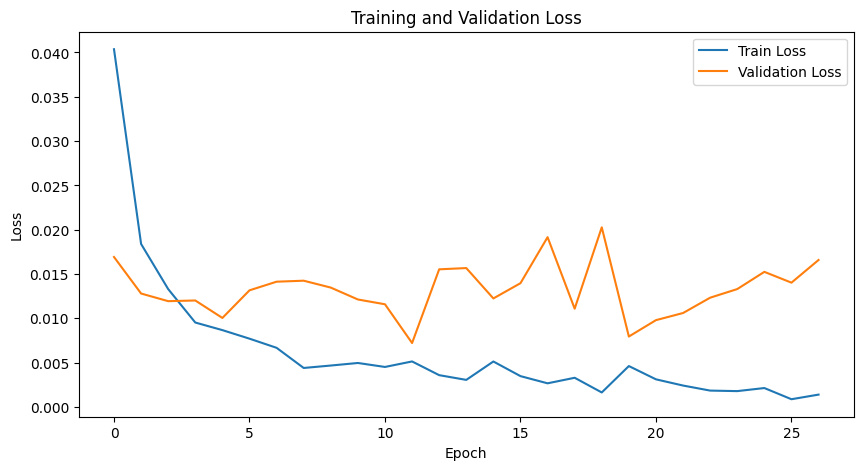

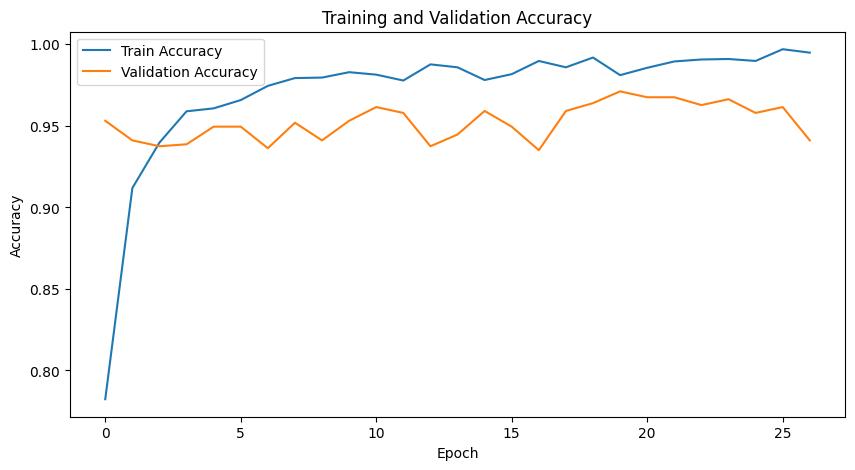

130/130 ━━━━━━━━━━━━━━━━━━━━ 42s 325ms/step - accuracy: 0.9514 - loss: 0.0210
Test Loss: 0.018389008939266205
Test Accuracy: 0.9509615302085876
Classification Report:
               precision    recall  f1-score   support

   leaf_spot       0.99      0.93      0.96       379
 Anthracnose       0.90      0.96      0.93       328
     Healthy       0.96      0.96      0.96       333

    accuracy                           0.95      1040
   macro avg       0.95      0.95      0.95      1040
weighted avg       0.95      0.95      0.95      1040



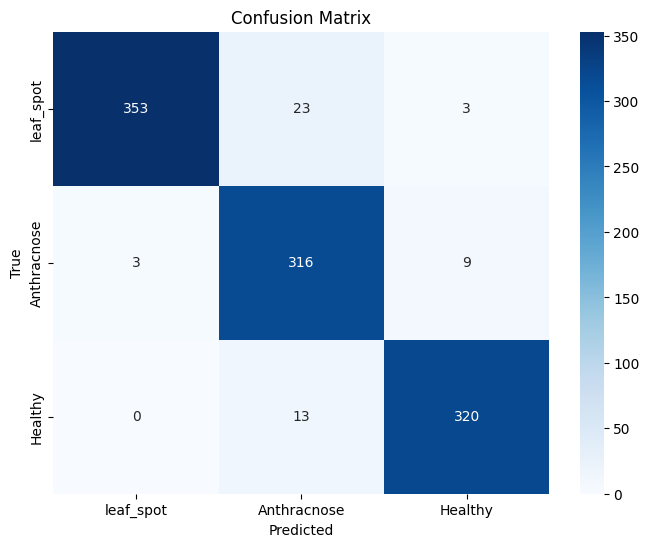

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1. Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 2. Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 3. Evaluate on Test Data
test_loss, test_accuracy = ensemble_model.evaluate(test_dataset, steps=steps_per_epoch_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# 4. Generate Predictions on Test Dataset
all_preds = []
all_true = []
# Iterate through test_dataset batches
for batch in test_dataset.take(steps_per_epoch_test):
    (num_data, img_data), labels = batch
    preds = ensemble_model.predict_on_batch((num_data, img_data))
    all_preds.append(preds)
    all_true.append(labels.numpy())

all_preds = np.vstack(all_preds)
all_true = np.vstack(all_true)

# Convert predictions to binary using threshold of 0.5 (for multi-label) or use argmax if each sample has one class.
# Here we assume one-hot encoded labels where each sample belongs to one class:
true_labels = np.argmax(all_true, axis=1)
pred_labels = np.argmax(all_preds, axis=1)

# 5. Classification Report
target_names = ["leaf_spot", "Anthracnose", "Healthy"]
report = classification_report(true_labels, pred_labels, target_names=target_names)
print("Classification Report:\n", report)

# 6. Confusion Matrix Visualization
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [8]:
import joblib

# Saving the scaler
joblib.dump(scaler, 'scaler.pkl')

# Loading the scaler later
scaler = joblib.load('scaler.pkl')
